In [1]:
# Import libraries 
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from typing import Dict, List, Optional, Sequence, Tuple
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi

from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

# Data exploration 

In [2]:
# Creating the required variables 
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback 
_SAMPLING_RATE = 16000

In [3]:
# Setting the path 
data_fp = pathlib.Path("../../asset/maestro-v2.0.0/") # root data folder 
filenames = glob.glob(str(data_fp/"**/*.mid*")) # find all the midi files in the root folder
print("Number of files: ", len(filenames))

Number of files:  1282


In [4]:
# Test with a sample file 
sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

print("Number of instruments: ", len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print("Instrument name: ", instrument_name)

../../asset/maestro-v2.0.0/2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.midi
Number of instruments:  1
Instrument name:  Acoustic Grand Piano


In [5]:
# Extract the notes 
for index, note in enumerate(instrument.notes[:10]): # look at the first 10 notes 
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f"{index}: pitch={note.pitch}, note_name={note_name}, duration={duration:.4f}")

0: pitch=75, note_name=D#5, duration=0.0677
1: pitch=63, note_name=D#4, duration=0.0781
2: pitch=75, note_name=D#5, duration=0.0443
3: pitch=63, note_name=D#4, duration=0.0469
4: pitch=75, note_name=D#5, duration=0.0417
5: pitch=63, note_name=D#4, duration=0.0469
6: pitch=87, note_name=D#6, duration=0.0443
7: pitch=99, note_name=D#7, duration=0.0690
8: pitch=87, note_name=D#6, duration=0.0378
9: pitch=99, note_name=D#7, duration=0.0742


* `pitch`: the perceptual quality of sound, determined by recognized by the MIDI note numbers. 
* `step variable`: represents the time elapsed from the previous note or start of the track. 
* `duration`: difference between the start time and end time of a note. 
##### These three parameters are what we will extract to construct the LSTM model network. 

In [6]:
# Extracting the notes from the sample MIDI file 

def midi_to_notes(midi_file: str) -> pd.DataFrame: 
    """Extract pitch, step variable, and duration from a given midi_file"""
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time 
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start) 
    prev_start = sorted_notes[0].start

    for note in sorted_notes: 
        start = note.start
        end = note.end 
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()}) # cast list to array in defaultlist 

In [7]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,63,1.001302,1.079427,0.000000,0.078125
1,75,1.006510,1.074219,0.005208,0.067708
2,75,1.305990,1.350260,0.299479,0.044271
3,63,1.305990,1.352865,0.000000,0.046875
4,75,1.630208,1.671875,0.324219,0.041667


In [8]:
# Converting to note names by considering the respective pitch values 
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
print(sample_note_names[:10])

['D#4' 'D#5' 'D#5' 'D#4' 'D#5' 'D#4' 'D#7' 'D#6' 'D#7' 'D#6']


In [9]:
# Visualizing the parameters of the musical notes of the piano 
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None): 
    if count: 
        title=f"First {count} notes"
    else: 
        title=f"Whole track"
        count = len(notes['pitch'])

    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes["start"], notes['end']], axis=0)

    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color='b', marker='.')
    plt.xlabel("Time [s]")
    plt.ylabel("Pitch")
    _ = plt.title(title)

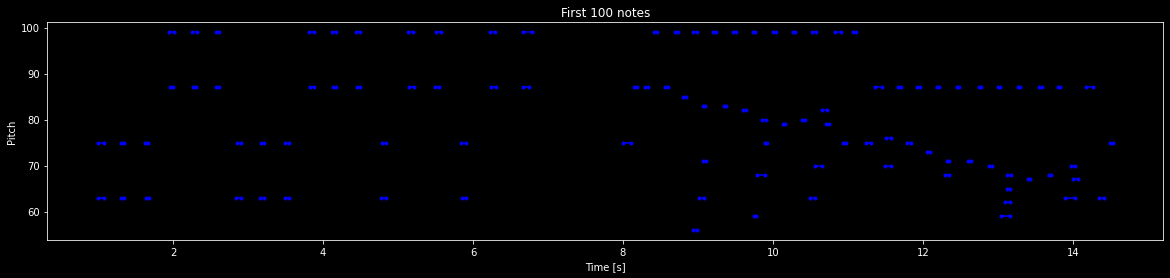

In [10]:
plot_piano_roll(raw_notes, 100)

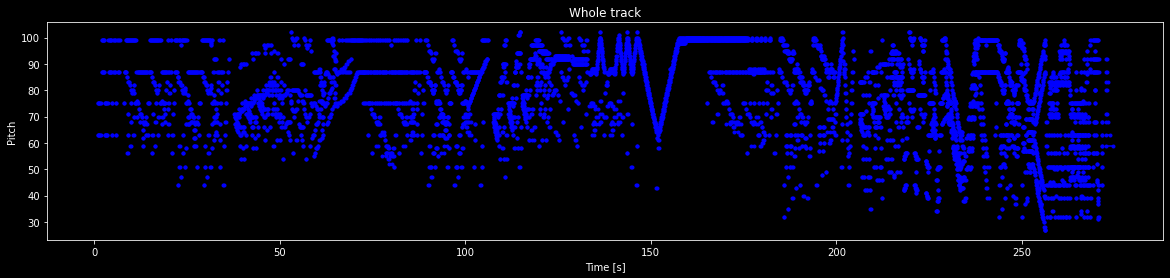

In [11]:
plot_piano_roll(raw_notes)

# Creating the training data

In [12]:
# MIDI data creation function 
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str, velocity: int = 100) -> pretty_midi.PrettyMIDI:
    """Generate MIDI files from musical notes; this is used to create dataset"""
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(instrument_name)
    )

    # (Re)construct the midi dataset
    prev_start = 0 
    for index, note in notes.iterrows(): 
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])

        note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']), start=start, end=end)

        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm 

In [13]:
example_file = './midi_data/example.midi'
example_pm = notes_to_midi(raw_notes, out_file=example_file, instrument_name=instrument_name)

In [14]:
# Extract all the notes from the MIDI files and create a dataset 
num_files = 5 # start small, and increase incrementally 
all_notes = []

# Concat all notes from selected files 
for f in filenames[:num_files]: 
    notes = midi_to_notes(f) 
    all_notes.append(notes)
all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
print("Number of notes parsed: ", n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1) # Re-store all three parameters as array 
print("Training notes' shape: ", train_notes.shape)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes) # Convert numpy arrays to tensorflow tensor datasets; this is faster 
notes_ds.element_spec

Number of notes parsed:  15435
Training notes' shape:  (15435, 3)
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-08-02 22:52:20.986890: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-02 22:52:20.987519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

From the PaperSpace Article 
> LSTMs, as discussed previously, work best with a series of information as they are able to effectively remember the previous data elements. Hence, the dataset we create will have sequence inputs and outputs. If the size of the sequence is (100, 1), that means that there will be a total of 100 input notes that will be passed to receive a final output of 1. Therefore, the dataset we create will have a similar pattern, where the data will have notes as the input features and an output note as a label following these input sequences.

In [15]:
# Check GPU availability 
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

2022-08-02 22:57:46.392975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-02 22:57:46.393043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


['/device:GPU:0']

In [19]:
def create_sequences(dataset: tf.data.Dataset, seq_length: int, vocab_size = 128) -> tf.data.Dataset: 
    """Create sequence inputs and outputs based on the created notes dataset. Return TF Dataset of sequence and label example"""
    seq_length = seq_length+1 # pad for one extra spot for the label 
    
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True) # each window is a dataset with a subset of elements 

    # flat_map flattens the window dataset ("dataset of datasets") into a dataset of tensors 
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch 
    def scale_pitch(x):
        x = x / [vocab_size, 1.0, 1.0]
        return x 

    # Split the labels 
    def split_labels(sequences): 
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i, key in enumerate(key_order)}
        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
seq_length, vocab_size = 25, 128 # seq_legnth is a hyperparameter that can be tuned later 
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

In [26]:
# take a look at the first element here
iter(seq_ds).next()

(<tf.Tensor: shape=(25, 3), dtype=float64, numpy=
 array([[0.6015625 , 0.        , 0.09244792],
        [0.3828125 , 0.00390625, 0.40234375],
        [0.5703125 , 0.109375  , 0.06510417],
        [0.53125   , 0.09895833, 0.06119792],
        [0.5703125 , 0.10807292, 0.05989583],
        [0.4765625 , 0.06640625, 0.05338542],
        [0.6015625 , 0.01302083, 0.0703125 ],
        [0.5703125 , 0.11979167, 0.07682292],
        [0.3984375 , 0.109375  , 0.43619792],
        [0.609375  , 0.00130208, 0.09505208],
        [0.5703125 , 0.12109375, 0.09244792],
        [0.609375  , 0.10807292, 0.0859375 ],
        [0.5703125 , 0.09375   , 0.08854167],
        [0.4765625 , 0.09635417, 0.05208333],
        [0.609375  , 0.01302083, 0.09635417],
        [0.5703125 , 0.11197917, 0.08854167],
        [0.4140625 , 0.09765625, 0.46614583],
        [0.625     , 0.00651042, 0.09635417],
        [0.5703125 , 0.11328125, 0.08203125],
        [0.625     , 0.10677083, 0.0859375 ],
        [0.5703125 , 0.0989583

In [27]:
# Generate training dataset
batch_size = 64 
buffer_size = n_notes - seq_length # this is the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [29]:
iter(train_ds).next()

2022-08-02 23:10:36.571457: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(64, 25, 3), dtype=float64, numpy=
 array([[[5.70312500e-01, 5.20833333e-03, 1.70572917e-01],
         [5.85937500e-01, 0.00000000e+00, 5.24739583e-01],
         [5.46875000e-01, 1.17187500e-02, 8.98437500e-02],
         ...,
         [4.53125000e-01, 3.90625000e-03, 3.12500000e-02],
         [6.01562500e-01, 1.27604167e-01, 1.11979167e-01],
         [5.78125000e-01, 1.28906250e-01, 1.30208333e-01]],
 
        [[5.07812500e-01, 1.10677083e-01, 1.60156250e-01],
         [3.82812500e-01, 3.12500000e-02, 5.07812500e-02],
         [3.98437500e-01, 1.36718750e-01, 3.90625000e-02],
         ...,
         [3.43750000e-01, 1.22395833e-01, 1.66666667e-01],
         [5.07812500e-01, 1.86197917e-01, 1.14583333e-01],
         [3.82812500e-01, 3.25520833e-02, 1.09375000e-01]],
 
        [[4.37500000e-01, 1.13281250e-01, 1.45833333e-01],
         [4.60937500e-01, 3.90625000e-03, 1.61458333e-01],
         [5.85937500e-01, 3.25520833e-02, 3.77604167e-02],
         ...,
         [4.2

## Developing a Model

In [30]:
"""Custom Loss Function: utilize step and duration parameters"""
# step and duraction are alwasy positive, and this loss function encourages that 
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor): 
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0) # 0 if y_pred is positive, <0 if y_pred is negative; presure the value to be positive
    return tf.reduce_mean(mse + positive_pressure)

In [32]:
# Custom Model with LSTM 
input_shape = (seq_length, 3)
learning_rate = 0.005 

# define input/output shape, and data flow 
inputs = Input(input_shape)
x = LSTM(128)(inputs)
outputs = {'pitch': Dense(128, name='pitch')(x),
            'step': Dense(1, name='step')(x),
            'duration': Dense(1, name='duration')(x),
            }

# construct the model with loss, optimizer 
model = Model(inputs, outputs)
loss = {'pitch': SparseCategoricalCrossentropy(from_logits=True),
        'step': mse_with_positive_pressure,  # apply our custom loss function 
        'duration': mse_with_positive_pressure, 
        }
optimizer = Adam(learning_rate=learning_rate)

# compile model
model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          67584       ['input_2[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_1[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_1[0][0]']                 
                                                                                            

In [33]:
# Define callbacks - checkpoints + early stopping 

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./training_checkpoints/ckpt_{epoch}', save_weights_only=True), # save training results and weights 
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5,  # early stopping when validation loss increase for 5 times
                                              verbose=1, restore_best_weights=True),] 

In [34]:
# Compiling and fitting the model

model.compile(loss = loss, 
              loss_weights = {'pitch': 0.05, 'step': 1.0, 'duration':1.0,},
              optimizer = optimizer)

epochs = 50

history = model.fit(train_ds, 
                    epochs=epochs, 
                    callbacks=callbacks,)

Epoch 1/50


2022-08-02 23:27:49.220812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-02 23:27:50.204399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-02 23:27:53.318907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - 10s 18ms/step - loss: 0.2793 - duration_loss: 0.0518 - pitch_loss: 4.1154 - step_loss: 0.0217
Epoch 2/50
240/240 [==============================] - 4s 17ms/step - loss: 0.2514 - duration_loss: 0.0416 - pitch_loss: 3.8684 - step_loss: 0.0164
Epoch 3/50
240/240 [==============================] - 4s 17ms/step - loss: 0.2448 - duration_loss: 0.0414 - pitch_loss: 3.7425 - step_loss: 0.0163
Epoch 4/50
240/240 [==============================] - 4s 17ms/step - loss: 0.2400 - duration_loss: 0.0408 - pitch_loss: 3.6583 - step_loss: 0.0162
Epoch 5/50
240/240 [==============================] - 4s 16ms/step - loss: 0.2374 - duration_loss: 0.0403 - pitch_loss: 3.6205 - step_loss: 0.0161
Epoch 6/50
240/240 [==============================] - 4s 17ms/step - loss: 0.2363 - duration_loss: 0.0401 - pitch_loss: 3.6034 - step_loss: 0.0160
Epoch 7/50
240/240 [==============================] - 4s 16ms/step - loss: 0.2346 - duration_loss: 0.0396 - pitch_loss: 3.5829 -

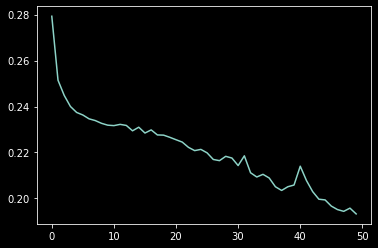

In [39]:
# evaluate the result through plot
plt.plot(history.history['loss'])

## Generating the notes

> Finally, we can use the trained model for generating the desired musical notes. For starting the iteration of the generation process, we will need to provide a starting sequence of notes upon which the LSTM model can continue to create building blocks and reconstruct more data elements. To create more randomness and avoid the model from picking only the best notes as it will lead to repetitive results, we can make use of the temperature parameter for random note generation. The below code snippet demonstrates the process of obtaining all the required results that we discussed in this section.

In [40]:
def predict_next_note(notes: np.ndarray, keras_model: tf.keras.Model, 
                      temperature: float = 1.0) -> int:
    """Generates a note IDs using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    # Extract output 
    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    # Apply randomness to the pitch 
    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1) # sample from random distribution 

    # Format output 
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

> With different temperature variables and different starting sequences, we can start generating our music accordingly. The procedure for this process is demonstrated in the code block below. We make use of a random starting sequence with a random temperature value using which the LSTM model can continue to build upon. As soon as we are able to interpret the next sequence and have the required pitch, step, and duration values, we can store them in a cumulative list of generation outputs. Then, we can proceed to delete the previously used starting sequence and make use of the next preceding one to make the next prediction and store it as well. This step can be continued for a range until we have a decent tone of music generated for the desired amount of time.

In [41]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes while the pitch is normalized similar to training sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0

for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

generated_notes.head(10)

2022-08-02 23:39:46.774220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-02 23:39:46.887893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step


,pitch,step,duration,start,end
0,71,0.074864,0.139150,0.074864,0.214013
1,63,0.304051,0.053217,0.378915,0.432132
2,98,0.291397,0.026557,0.670312,0.696869
3,100,0.286738,0.015521,0.957050,0.972571
4,98,0.293955,0.010235,1.251005,1.261240
5,98,0.285015,0.000000,1.536020,1.536020
6,27,0.298652,0.000000,1.834672,1.834672
7,91,0.259956,0.000000,2.094628,2.094628
8,89,0.274855,0.000000,2.369483,2.369483
9,78,0.254901,0.000000,2.624384,2.624384


In [42]:
# Save the notes to midi file
out_file = 'output.midi'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)